### installations and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import praw
import torch
import requests
import time
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.special import softmax

### fetch bitcoin data and reddit news

In [2]:
crypto_currency = 'BTC-USD'

start_date = dt.datetime.now() - dt.timedelta(days=730)
end_date = dt.datetime.now()

try:
    # Retrieve cryptocurrency data with hourly interval
    data = yf.download(tickers=crypto_currency, start=start_date, end=end_date, interval='1h')
    
    print(data)
except Exception as e:
    print(f"Error retrieving data: {e}")

[*********************100%%**********************]  1 of 1 completed

                                   Open          High           Low  \
Datetime                                                              
2022-08-18 21:00:00+00:00  23423.595703  23426.787109  23373.750000   
2022-08-18 22:00:00+00:00  23378.291016  23392.771484  23353.519531   
2022-08-18 23:00:00+00:00  23360.189453  23375.500000  23177.601562   
2022-08-19 00:00:00+00:00  23213.312500  23213.312500  22923.712891   
2022-08-19 01:00:00+00:00  22954.023438  22954.023438  22755.345703   
...                                 ...           ...           ...   
2024-08-17 15:00:00+00:00  59539.410156  59624.292969  59398.585938   
2024-08-17 16:00:00+00:00  59402.105469  59639.453125  59402.105469   
2024-08-17 17:00:00+00:00  59624.519531  59669.039062  59471.574219   
2024-08-17 18:00:00+00:00  59454.242188  59474.464844  59336.445312   
2024-08-17 19:00:00+00:00  59413.468750  59502.476562  59413.468750   

                                  Close     Adj Close     Volume  
Datetime 

In [3]:
import pandas as pd
import numpy as np
import re
import praw
import datetime as dt
from transformers import BertTokenizer, BertForSequenceClassification, AutoConfig
from scipy.special import softmax
import pytz

# Reddit API credentials
reddit = praw.Reddit(client_id='-DikpAFUeeajlFFyWTBqUg',
                     client_secret='yZu1rPuBINVPuI7LuugQybGwtX1Cdg',
                     user_agent='bitcoin data')

# Load the model, tokenizer, and config
MODEL = "kk08/CryptoBERT"
tokenizer = BertTokenizer.from_pretrained(MODEL)
model = BertForSequenceClassification.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# Define batch size (number of hours per batch)
batch_size = 24 * 7  # Fetch posts for a week at a time

# Generate sentiment data corresponding to each hour in your dataset
sentiment_data = []

# Loop through your data in batches of `batch_size`
for i in range(0, len(data), batch_size):
    batch_start, batch_end = data.index[i], data.index[min(i + batch_size - 1, len(data) - 1)]
    batch_start = batch_start.tz_convert(pytz.UTC)
    batch_end = batch_end.tz_convert(pytz.UTC)
    hourly_sentiments = {hour: [] for hour in pd.date_range(start=batch_start, end=batch_end, freq='h')}

    for submission in reddit.subreddit('cryptocurrency').search('bitcoin'):
        post_time = dt.datetime.fromtimestamp(submission.created_utc, tz=pytz.UTC)
        
        # Print out each submission's details to inspect data
        print(f"Post Time: {post_time}, Title: {submission.title}, Selftext: {submission.selftext}")

        if batch_start <= post_time <= batch_end:
            combined_text = submission.title + " " + submission.selftext
            combined_text = " ".join(['@user' if t.startswith('@') and len(t) > 1 else 'http' if t.startswith('http') else t for t in combined_text.split()])

            # Print the combined text to inspect what is being analyzed
            print(f"Combined Text for Analysis: {combined_text}")

            # Tokenize with truncation
            encoded_input = tokenizer(combined_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            output = model(**encoded_input)
            scores = softmax(output.logits[0].detach().numpy())
            sentiment_score = scores[config.label2id["LABEL_1"]] - scores[config.label2id["LABEL_0"]]

            # Print the sentiment score to see the results of the analysis
            print(f"Sentiment Score: {sentiment_score}")

            post_hour = post_time.replace(minute=0, second=0, microsecond=0)
            if post_hour in hourly_sentiments:
                hourly_sentiments[post_hour].append(sentiment_score)

    for hour, sentiments in hourly_sentiments.items():
        sentiment_data.append(np.mean(sentiments) if sentiments else 0)

# Align sentiment data with the data index
data['Sentiment'] = pd.Series(sentiment_data[:len(data)], index=data.index[:len(sentiment_data)])

# Print the final sentiment data to ensure it's correctly aligned
print(data['Sentiment'])

Post Time: 2021-05-20 12:02:32+00:00, Title: A Mysterious Bitcoin Whale who sold 3000 Bitcoins at 58K$, Bought back 3521 Bitcoins in the last three days, Selftext: 
Post Time: 2024-01-10 20:44:59+00:00, Title: Bitcoin spot ETF finally approved, Selftext: 
Post Time: 2024-01-12 09:31:42+00:00, Title: Bitcoin Vs. Bitcoin Spot ETFs: the great illusion has started. Beware., Selftext: It is quite shocking to see that so many people have completely misunderstood Bitcoin in recent days and hours.

Or maybe these so-called Bitcoiners are finally revealing their true colors by showing that only greed has always guided them...

With the approval of Bitcoin Spot ETFs, some even believe that the mass adoption of Bitcoin by the general public has started...

Unfortunately, this is not the case.

Even if these financial products are phenomenally successful, this will in no way mean that mass adoption has started for Bitcoin.

Bitcoin aims to free us from these intermediaries who abuse people's trust

In [4]:

print(f"Length of sentiment_data: {len(sentiment_data)}")
print(f"Length of data.index: {len(data.index)}")

# Ensure the length of sentiment_data matches data.index
if len(sentiment_data) != len(data.index):
    print(f"Length mismatch: sentiment_data ({len(sentiment_data)}) vs data.index ({len(data.index)})")
    # Trimming or extending sentiment_data as necessary
    if len(sentiment_data) > len(data.index):
        sentiment_data = sentiment_data[:len(data.index)]
    else:
        # If shorter, you might need to pad sentiment_data with neutral scores (0)
        sentiment_data.extend([0] * (len(data.index) - len(sentiment_data)))

# Convert sentiment data into a pandas Series and add to your DataFrame
data['Sentiment'] = pd.Series(sentiment_data, index=data.index[:len(sentiment_data)])

Length of sentiment_data: 17519
Length of data.index: 17435
Length mismatch: sentiment_data (17519) vs data.index (17435)


In [13]:
print(sentiment_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
print(data)

                                   Open          High           Low  \
Datetime                                                              
2022-08-18 19:00:00+00:00  23337.435547  23426.742188  23327.572266   
2022-08-18 20:00:00+00:00  23371.490234  23431.685547  23344.886719   
2022-08-18 21:00:00+00:00  23423.595703  23426.787109  23373.750000   
2022-08-18 22:00:00+00:00  23378.291016  23392.771484  23353.519531   
2022-08-18 23:00:00+00:00  23360.189453  23375.500000  23177.601562   
...                                 ...           ...           ...   
2024-08-17 13:00:00+00:00  59240.937500  59427.179688  59226.101562   
2024-08-17 14:00:00+00:00  59323.671875  59520.984375  59291.769531   
2024-08-17 15:00:00+00:00  59539.410156  59624.292969  59398.585938   
2024-08-17 16:00:00+00:00  59402.105469  59639.453125  59402.105469   
2024-08-17 17:00:00+00:00  59624.519531  59669.039062  59503.257812   

                                  Close     Adj Close     Volume  Sentiment 

### prepare data

In [5]:
# Define the features you want to use in your model
# You can easily modify this list to include or exclude features
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sentiment']

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data using the selected features
# This will scale all the features you specified in the 'features' list
scaled_data = scaler.fit_transform(data[features])

# Define prediction hours (e.g., using the past 60 hours to predict the next hour)
prediction_hours = 60

# Prepare the training data
x_train, y_train = [], []

# Loop over the data to create training sequences
for x in range(prediction_hours, len(scaled_data)):
    # Include all selected features in x_train
    # We take the past 'prediction_hours' of data for the selected features
    x_train.append(scaled_data[x-prediction_hours:x, :])  # This includes all features in 'features'

    # Use only the 'Close' price for y_train
    # We are predicting the 'Close' price at time x
    y_train.append(scaled_data[x, features.index('Close')])  # Index of 'Close' in the selected features

# Convert the lists to NumPy arrays for use in the model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the input data to the required shape for the model
# The shape needs to be (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features)))  # Number of features is dynamic

# Print the shapes to verify
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (17375, 60, 7)
y_train shape: (17375,)


### create neural network

In [26]:
# Initialize the model
model = Sequential()

# First LSTM layer with bidirectional LSTM and adjusted number of units
model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting

# Second LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))

# Output layer: predicting 1 value (the 'Close' price)
model.add(Dense(units=1))

# Compile the model with the Adam optimizer and mean squared error loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model on the training data
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
 36/543 [>.............................] - ETA: 40:45 - loss: 0.0089

In [6]:
# Initialize the model
model = Sequential()

# First LSTM layer with bidirectional LSTM and adjusted number of units
model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting

# Second LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))

# Output layer: predicting 1 value (the 'Close' price)
model.add(Dense(units=1))

# Compile the model with the Adam optimizer, but include learning rate tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Introduce early stopping and learning rate reduction on plateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model on the training data with validation split
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])


Epoch 1/20
435/435 [==============================] - 37s 58ms/step - loss: 0.0017 - val_loss: 6.9573e-04 - lr: 0.0010
Epoch 2/20
435/435 [==============================] - 22s 52ms/step - loss: 7.3063e-04 - val_loss: 0.0027 - lr: 0.0010
Epoch 3/20
435/435 [==============================] - 21s 49ms/step - loss: 6.9047e-04 - val_loss: 3.9688e-04 - lr: 0.0010
Epoch 4/20
435/435 [==============================] - 18s 42ms/step - loss: 5.8544e-04 - val_loss: 6.9263e-04 - lr: 0.0010
Epoch 5/20
435/435 [==============================] - 18s 42ms/step - loss: 5.3863e-04 - val_loss: 4.0532e-04 - lr: 0.0010
Epoch 6/20
435/435 [==============================] - 18s 42ms/step - loss: 4.8078e-04 - val_loss: 8.1837e-04 - lr: 0.0010
Epoch 7/20
435/435 [==============================] - 18s 42ms/step - loss: 4.3258e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 8/20
435/435 [==============================] - 18s 42ms/step - loss: 4.5336e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 9/20
435/435 [============

### testing the data

In [15]:
# Define the date range for testing
test_days = 60
total_days = 730

# Assuming `data` contains all data from now to 730 days back, including 'Close' and another feature (e.g., 'Volume')
# Split the data into training and testing sets
train_data = data[:-test_days]
test_data = data[-test_days:]

# Get the actual prices
actual_prices = test_data['Close'].values

# Combine the training data with the test data for both features
total_dataset = pd.concat((train_data[['Close', 'Volume']], test_data[['Close', 'Volume']]), axis=0)

# Prepare model inputs with both features
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_hours:].values

# Scale only the 'Close' prices separately for prediction and inverse transform
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_close.fit(total_dataset[['Close']])

# Transform the 'Close' prices separately
model_inputs_close = scaler_close.transform(total_dataset[['Close']].values)

# Combine the 'Close' prices back with other features (e.g., 'Volume')
scaled_data = np.hstack((model_inputs_close, model_inputs[:, 1:]))

# Prepare the test data for predictions
x_test = []
for x in range(prediction_hours, len(scaled_data)):
    x_test.append(scaled_data[x-prediction_hours:x, :])

x_test = np.array(x_test)

# Make predictions
predicted_prices = model.predict(x_test)

# Inverse transform only the predicted 'Close' prices
predicted_prices = scaler_close.inverse_transform(predicted_prices)

# Flatten predicted prices to match shape if needed
predicted_prices = predicted_prices.flatten()

# Print the predicted prices
print(predicted_prices)

# Plot the predicted and actual prices for comparison
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, color='black', label='Actual BTC-USD price')
plt.plot(predicted_prices, color='green', label='Predicted BTC-USD price')
plt.title('BTC-USD price prediction')
plt.xlabel('Time')
plt.ylabel('BTC-USD Price')
plt.legend()
plt.show()


c:\Users\malik\.conda\envs\bitcoin\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 17435 and the array at index 1 has size 120

### predict next day

In [7]:
# Number of hours to predict (12 hours)
num_hours_to_predict = 24

# Initialize the input data with the last `prediction_hours` before the prediction starts
start_index = len(scaled_data) - prediction_hours - num_hours_to_predict
real_data = scaled_data[start_index:start_index + prediction_hours, :]  # Use all features
real_data = np.array(real_data)

# Reshape to match the model's expected input shape (1, time steps, features)
real_data = np.reshape(real_data, (1, real_data.shape[0], real_data.shape[1]))  # Shape (1, 60, 7) for example

predicted_prices = []

for _ in range(num_hours_to_predict):
    # Predict the next hour's price
    predicted = model.predict(real_data)
    
    # Extract the scalar value from the predicted array
    predicted_value = predicted[0, 0]  # Extract the single predicted valuea

    # Create an array to hold the predicted value along with other features
    predicted_extended = np.zeros((1, len(features)))  # Initialize with zeros for all features
    predicted_extended[0, features.index('Close')] = predicted_value  # Assign predicted value to 'Close'

    # Ensure that `predicted_extended` has the same shape as the data that was used to fit the scaler
    predicted_price = scaler.inverse_transform(predicted_extended)[0, features.index('Close')]
    predicted_prices.append(predicted_price)
    
    # Update real_data by removing the oldest data and appending the new prediction
    new_input = np.append(real_data[0][1:], predicted_extended, axis=0)  # Update the input data
    real_data = np.reshape(new_input, (1, new_input.shape[0], len(features)))  # Reshape back to (1, 60, 7)

# Extract only the 'Close' prices for the last `num_hours_to_predict` hours for comparison
actual_prices_close_only = scaled_data[-num_hours_to_predict:, features.index('Close')].reshape(-1, 1)  # Extract 'Close'

# Create a dummy array with the correct number of features (7 in this case)
dummy_array = np.zeros((actual_prices_close_only.shape[0], len(features)))  # Shape (12, 7)

# Replace the 'Close' column with the actual 'Close' prices
dummy_array[:, features.index('Close')] = actual_prices_close_only[:, 0]  # Assign 'Close' prices to the correct column

# Perform inverse transformation using the dummy array
actual_prices = scaler.inverse_transform(dummy_array)[:, features.index('Close')]

# Print the predicted prices for the next 12 hours
print(f'Predicted prices for the next {num_hours_to_predict} hours: {predicted_prices}')

# Print the actual prices for the last 12 hours
print(f'Actual prices for the last {num_hours_to_predict} hours: {actual_prices}')


1/1 [==============================] - 0s 94ms/step
Predicted prices for the next 24 hours: [59074.46597877709, 56636.754343340406, 53683.80826884601, 50591.859613158915, 47593.24219905748, 44838.59307855426, 42432.08909860006, 40390.36375486551, 38715.509180679044, 37401.24552369013, 36408.44885494746, 35700.61386452551, 35234.34777386801, 34963.15585426093, 34848.380246058805, 34851.313030320365, 34938.997928574914, 35081.09037664707, 35261.6594351902, 35447.997396030056, 35640.04211659252, 35821.49498063413, 35986.134826013236, 36130.92874987665]
Actual prices for the last 24 hours: [59284.015625   59020.9375     58994.40625    58921.3359375
 59216.75390625 59226.5390625  59163.39453125 59169.5859375
 59236.61328125 59200.90234375 59179.9453125  59254.8359375
 59274.9765625  59310.4765625  59117.69921875 59131.69921875
 59239.24609375 59318.86328125 59511.67578125 59403.328125
 59619.1953125  59471.57421875 59425.55859375 59493.0625    ]


In [8]:
# Ensure the lengths of actual_prices and predicted_prices match
aligned_actual_prices = actual_prices[-len(predicted_prices):]  # Trim actual_prices to the same length as predicted_prices

# Calculate and print the mean squared error
mse = mean_squared_error(aligned_actual_prices, predicted_prices)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 415266852.4228616
Root Mean Squared Error: 20378.097370040745


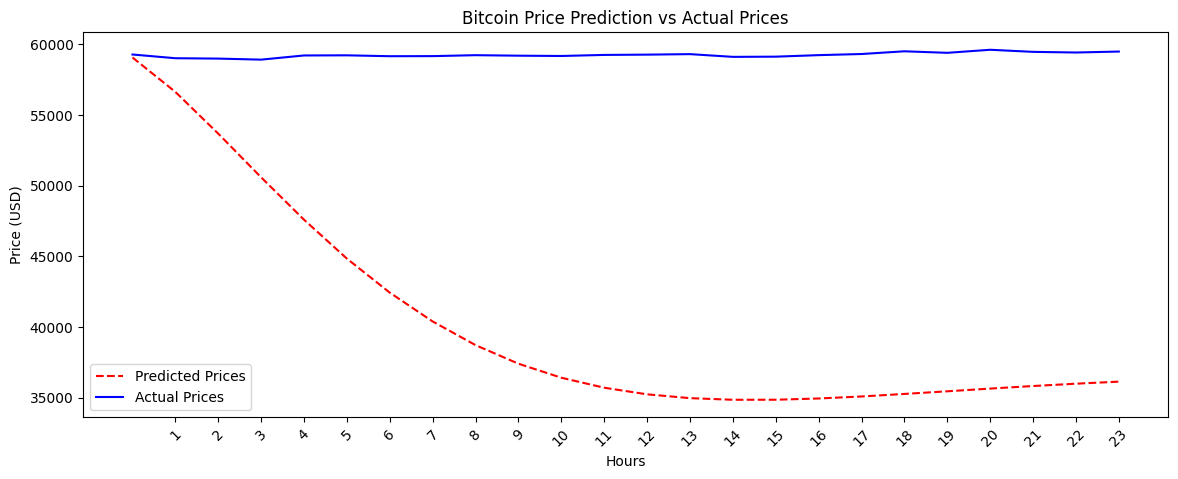

In [10]:
# Ensure the lengths of predicted_prices and actual_prices match
predicted_prices = np.array(predicted_prices)  # Convert to numpy array if not already
actual_prices = actual_prices[-len(predicted_prices):]  # Match the length of actual_prices to predicted_prices

# Optionally, plot the predicted and actual prices for comparison
plt.figure(figsize=(14, 5))
plt.plot(range(len(predicted_prices)), predicted_prices, color='red', linestyle='dashed', label='Predicted Prices')
plt.plot(range(len(actual_prices)), actual_prices, color='blue', linestyle='solid', label='Actual Prices')
plt.title('Bitcoin Price Prediction vs Actual Prices')
plt.xlabel('Hours')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(range(1, len(predicted_prices), 1), rotation=45)  # Label every 24 hours
plt.show()